# Puffer Analysis

You use this notebook to explore the Puffer data evaluation results and/or recreate the following figures:

**Main paper:**
- Figure 1
- Figure 4

**Appendix:**
- Figure 10
- Figure 14
- Figure 15
- Figure 16
- Figure 17

For a simpler overview of the evaluation data, see the [demo notebook](demo.ipynb).

## Prerequisites

You must download and evaluate the puffer data, which you can do by running the following CLI commands:

```bash
./run.py puffer-download

# Optional, but strongly recommended if you plan to run all experiments.
./run.py puffer-preprocess

./run.py puffer-analysis
```

_Warning_: The full dataset consists of several hundred GB of data and the download and evaluation may take several hours. Each day takes about 5-10 minutes each do download and analyze, depending on your setup.
Preprocessing the data takes about 3 minutes per day (can be parallelized) and prepares the Puffer "TTP" model input/output from the dataset. If you do not preprocess the data, this step is done on the fly when running the analysis. If you also plan to run the replay experiments, we recommend preprocessing the data to save a lot of time. However, the full dataset, including preprocessed data, will take about 1TB of disk space.



The experiments are structured by day and you may only download and evaluate a subset of data to experiment with the notebook.
You can do this select experiments with glob patterns.
For example, the most recent Memento deployment started in September 2022. To load only the data since them, you can run:

```bash
./run.py puffer-download "2022-09-*" "2022-1*" "2023-*"
./run.py puffer-analysis "2022-09-*" "2022-1*" "2023-*"
```

See `REAMDE.md` for additional CLI options such as verbosity, running experiments in parallel, or scheduling jobs with Slurm.

## Imports and Settings

In [1]:
import sys
sys.path.append('..')  # To allow imports from parent directory
%load_ext autoreload
%autoreload 2

In [2]:
from operator import itemgetter

import experiment_helpers as eh
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
from experiment_helpers.data import Path
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy import stats

# Load the config, including the local config.
from config import Config as LocalConfig  # Load from file: ../config.py
from experiments.puffer.config import PufferExperimentConfig

config = PufferExperimentConfig.with_updates(LocalConfig)

In [3]:
# Plot import and configuration.
%matplotlib inline

# Set theme and parameters
eh.plot_utils.setup(latex=True)

plotdir = Path("../plots/puffer-analysis")
plotdir.mkdir(exist_ok=True, parents=True)

In [4]:
# Load the config, including the local config.
from config import Config as LocalConfig  # File: ../config.py
from experiments.puffer.config import PufferExperimentConfig
config = PufferExperimentConfig.with_updates(LocalConfig)

evaldir = config.output_directory / "puffer-analysis"
print(f"{len(list(evaldir.iterdir()))} evaluated days found.")

1195 evaluated days found.


## Important dates

We need these points in time to select appropriate time ranges.

In [5]:
# Important dates for the analysis.
# First day of the current deployed version of Memento
deployment_start = pd.to_datetime("2022-09-19")
# First day of the previous deployment with a different version of Memento.
old_deployment_start = pd.to_datetime("2022-05-01")
# The last day for which a daily-retrained Fugu model is available.
last_fugu_day = pd.to_datetime("2022-10-05")  
# The last day considered for the analysis.
cutoff_day = pd.to_datetime("2023-07-17")

## Constants

Here we define importants days to filter the data as well as pretty display names and colors for the figures.

In [6]:
# Pretty tex names.
#bba_name = r"\textsf{BBA}"
fugu_name = r"\textsf{Fugu}"
fugufeb_name = r"\textsf{Fugu} (static)"
memento_name = r"\textsf{Memento}"
memento_deterministic = r"\textsf{Memento} (T\texttt{=}0)"

# Map dataframe names to pretty names.
name_mapping = {
    #'bba': bba_name,
    'fugu-feb': fugufeb_name,
    'fugu': fugu_name,
    'memento': memento_name,
    'memento-deterministic': memento_deterministic,
}

# A consistent order for ABRs across plots.
abr_order = [  # Easier sorting
    memento_name, memento_deterministic, fugu_name, fugufeb_name, #bba_name
]
abr_order_short = [  # Exlude Fugu (keep FuguFeb)
    memento_name, memento_deterministic, fugufeb_name,
]

# A consistent color palette for ABRs across plots.
base_palette = sns.color_palette("deep")
abr_palette = {
    memento_name: base_palette[2],           # green
    memento_deterministic: base_palette[3],  # red
    fugu_name: base_palette[1],              # orange
    fugufeb_name: base_palette[0],           # blue
}

# Helper functions

- Weighted mean (so we can average over days with different amounts of data)
- absolute difference and maximum percent difference for metric comparisons.

In [7]:
def weighted_mean(frame, columns, weightcolumn="weight"):
    """Compute the weighted mean for a dataframe."""
    values = frame[columns].values
    weights = frame[weightcolumn].values if weightcolumn else None
    return weighted_mean_raw(values, weights)

def weighted_mean_raw(values, weights=None):
    if weights is None:
        return np.mean(values, axis=0)
    else:
        weights = np.asarray(weights)
        # Add dimensions in case values is 2d.
        weights = \
            weights[(..., ) + (np.newaxis,) * (values.ndim - weights.ndim)]
        return (values * weights).sum(axis=0) / weights.sum()
    
def diff(x, y):
    """Compute the absolute difference of two values."""
    return (x - y)

def maxpd(x, y):
    """Compute the maximum percentage difference of two values."""
    return 100 * (x - y) / np.maximum(np.abs(x), np.abs(y))

## Load raw data

First, load the raw evaluation data.

Over time, we deployed several version of Memento. For the following plots, we only keep the two most recent deployments. We keep past data from past ABRs, but discard outdated Memento versions to avoid confusion.

In [8]:
_frames = []
for daydir in evaldir.iterdir():
    _resfile = daydir / "results.csv.gz"
    if not _resfile.is_file():
        continue
    _frames.append(eh.data.read_csv(_resfile, parse_dates=['day']))

raw_results = (
    pd
    .concat(_frames, ignore_index=True)
    .assign(
        # For each frame, apply name mapping and use a categorical
        # datatype to ensure consistent ordering and to save space.
        abr=lambda df: pd.Categorical(
            df['abr'].replace(name_mapping), abr_order),
    )
    .dropna(subset=['abr'])  # Drop rows without relevant ABR.
    # Remove Memento versions from old deployments, i.e. keep non-Memento
    # for the whole range and Memento only since the current deployment.
    .query("not ((abr in [@memento_name, @memento_deterministic]) and "
                "(day < @old_deployment_start)) and (day < @cutoff_day)")
)


## Remove an outlier for Fugu (static)
# On a single day (2022-12-10), Fugu-Feb reports 80h of rebuffering.
# After closer investigation, this is caused by a single stream reporting 
# almost all of this rebuffering time. We exclude this day from the analysis.
raw_results = raw_results.query("day != @pd.to_datetime('2022-12-10')")

## Remve and outlier for Fugu (daily)
# For similar reasons we exclude 2022-07-07. On this day the data publihsed
# for Fugu (daily) shows 40% of stream-time spent stalled, more than 20x the
# next highest value. We exclude this day to not skew the results.
raw_results = raw_results.query("day != @pd.to_datetime('2022-07-07')")

# Quick check how much data we loaded.
print("Days with results per ABR:")
display(
    raw_results
    .groupby('abr')
    ['day'].nunique()
)

print("Days with results per ABR (only current Memento deployment):")
display(
    raw_results
    .query("day >= @deployment_start")
    .groupby('abr')
    ['day'].nunique()
)

# Also, let's have a peek at the data structure. It's a long-form frame.
raw_results.head()

Days with results per ABR:


abr
\textsf{Memento}                    428
\textsf{Memento} (T\texttt{=}0)     428
\textsf{Fugu}                       884
\textsf{Fugu} (static)             1170
Name: day, dtype: int64

Days with results per ABR (only current Memento deployment):


abr
\textsf{Memento}                   292
\textsf{Memento} (T\texttt{=}0)    292
\textsf{Fugu}                       17
\textsf{Fugu} (static)             292
Name: day, dtype: int64

,abr,metric,value,variable,selection,day
0,\textsf{Fugu},mean,17.414953,ssim,all,2020-05-19
1,\textsf{Fugu},std,0.045691,ssim,all,2020-05-19
2,\textsf{Fugu},rms,17.428331,ssim,all,2020-05-19
3,\textsf{Fugu},0.0,5.686266,ssim,all,2020-05-19
4,\textsf{Fugu},0.001,8.160825,ssim,all,2020-05-19


The data is stored in [long (also called narrow) format][1]. The context of each value is given by:
- `day`: The evaluated day.
- `abr` The evaluated algorithm.
- `selection`: We evaluate three subsets of data.
  - `all`: All data.
  - `stalled`: Only results of sessions experiencing stalls.
  - `unstalled`: Only results of sessions not experiencing stalls.
- `variable`: Which aspect of the data is evaluated. Some important variables are:
  - `ssim`: Image quality of all video chunks.
  - `stream`: Time info for the stream, e.g. playtime and rebuffering time.
- `metric`: For each variable, we compute several aggregate statistics. E.g. for SSIM, we evaluate mean, std, and several percentiles.

Next, we select the `(variable, metric)` combinations we are going to plot and give them a nice name for visualization in a single column called `varmetric`.

[1]: https://en.wikipedia.org/wiki/Wide_and_narrow_data

In [9]:
# Mapping from (variable, variable metric) to high level metric label.
metrics = {
    # Number of sessions and video chunks
    ("session", "count"): "\# Sessions",
    ("chunk", "count"): "\# Chunks",
    # Stream time.
    ("stream", "streamtime"): "Time streamed",  # Play + buffer time.
    ("stream", "playtime"): "Time played",
    ("stream", "rebuftime"): "Time stalled",
    ("stream", "stalled"): "Percent stalled",  # Time stalled / Time streamed
    # Image quality (SSIM).
    ("ssim", "mean"): "Mean SSIM",
    # Prediction scores.
    ("logscore_0", "mean"): "Score Mean",
    ("logscore_0", '0.5'): "Score Median",
    ("logscore_0", '0.01'): "Score Tail",
}
# Consistent sorting of metrics.
metric_order = list(metrics.values())

# Metrics with linear scale. We will look at percentage differences below,
# but these are only meaningful for these metrics.
metrics_linear = [
    '\# Sessions', '\# Chunks',
    'Time streamed', 'Time played', 'Time stalled', 'Percent stalled',
    'Median SSIM', 'Mean SSIM',
    'Median $\Delta$SSIM', 'Mean $\Delta$SSIM',
]

filtered_results = (
    raw_results
    .assign(
        varmetric=lambda df:
            df[['variable', 'metric']].apply(tuple, axis=1).map(metrics),
        days_running=lambda df: (df['day'] - deployment_start).dt.days,
    )
    .dropna(subset=["varmetric"])  # Drop unsued variable/metric combos
    .drop(columns=['metric', 'variable'])  # Drop individual columns.
)

# Let's have a look again.
filtered_results.head()

,abr,value,selection,day,varmetric,days_running
0,\textsf{Fugu},17.414953,all,2020-05-19,Mean SSIM,-853
36,\textsf{Fugu} (static),17.493511,all,2020-05-19,Mean SSIM,-853
108,\textsf{Fugu},532324.029000,all,2020-05-19,Time played,-853
109,\textsf{Fugu},2530.783000,all,2020-05-19,Time stalled,-853
110,\textsf{Fugu},534854.812000,all,2020-05-19,Time streamed,-853


# Aggregate statistics per ABR

First of all, let's aggregate the statistics per ABR over the whole duration.
We also include a measure of "stream-years" similar to the original Puffer paper

In [10]:
SECONDS_PER_HOUR = 3600
SECONDS_PER_YEAR = 31556952

def aggregate_stats(frame):
    """Aggregate stats per abr."""
    full = frame.query("selection == 'all'")
    stalled = frame.query("selection == 'stalled'")

    n_days = (
        full
        .groupby('abr')
        ['day']
        .nunique()
        .to_frame('\# Days')
    )

    n_sessions = (
        full
        .query("varmetric == '\# Sessions'")
        .groupby('abr')
        ['value']
        .sum()
        .to_frame('\# Sessions')
    )

    average_ssim = (
        full
        .query("varmetric == 'Mean SSIM'")
        .groupby('abr')
        ['value']
        .mean()
        .to_frame('Mean SSIM')
    )

    stream_years = (
        full
        .query("varmetric == 'Time played'")
        .groupby("abr")
        ["value"]
        .sum()
        .to_frame("Stream-years")
        / SECONDS_PER_YEAR  # Scale to stream-years.
    )

    def _sum(df):
        """Sum by ABR."""
        return df.groupby(['abr'])['value'].sum()

    percent_time_stalled = (
        (
            # Time stalled.
            _sum(full.query("varmetric == 'Time stalled'")) /
            _sum(full.query("varmetric == 'Time streamed'"))
            * 100
        )
        .to_frame("Time stalled [\%]")
    )

    hours_stalled = (
        _sum(full.query("varmetric == 'Time stalled'")) / SECONDS_PER_HOUR
    ).to_frame("Time stalled [h]")

    return pd.concat([
        n_days, n_sessions, stream_years,
        average_ssim,
        #percent_sessions_stalled, 
        percent_time_stalled,
        hours_stalled
    ], axis=1)


print("Aggregate stats since the start of the current deployment.")
aggregate = aggregate_stats(filtered_results.query("day >= @deployment_start"))
display(aggregate)

Aggregate stats since the start of the current deployment.


,\# Days,\# Sessions,Stream-years,Mean SSIM,Time stalled [\%],Time stalled [h]
abr,,,,,,
\textsf{Memento},292,757276.0,10.793034,17.119346,0.203985,193.384024
\textsf{Memento} (T\texttt{=}0),292,766122.0,10.920469,16.386746,0.208425,199.935087
\textsf{Fugu},17,45932.0,0.540400,17.710705,0.203059,9.638569
\textsf{Fugu} (static),292,762989.0,10.851673,17.143030,0.237219,226.188266


Also, compute the overall difference (in percent) between Memento and Fugu (static).

We can only compare against a static version of Fugu, as the version of Fugu retrained daily from random samples was discontinued only a couple of days into the current deployment, too little to draw any conclusions.
We will analyze the daily-retrained version compared to static Fugu afterwards.

The default Memento has about the the same image quality (onlt 0.8% worse) as the dailt retrained Fugu, but users spend about 14% less of their stream time stalled: 0.2 of total stream time vs 0.23%. Overall, stalls are rare, they are the "tail" of the distribution.


(Differences are shown in percent)

In [11]:
maxpd(
    aggregate.loc[[memento_name, memento_deterministic]],
    aggregate.loc[fugufeb_name].values
)

,\# Days,\# Sessions,Stream-years,Mean SSIM,Time stalled [\%],Time stalled [h]
abr,,,,,,
\textsf{Memento},0.0,-0.748766,-0.540366,-0.138156,-14.009927,-14.503070
\textsf{Memento} (T\texttt{=}0),0.0,0.408943,0.629974,-4.411612,-12.138284,-11.606782


Now compare Fugu (daily) and fugu_static during the whole time when both algorithms were deployed.
Users that got assigned the daily-retrained model only spent 4% smaller fraction of their stream-time stalled overall, with almost identical image quality.

(Differences are shown in percent)

In [12]:
both_fugus = (  # Days for with we have both Fugu and FuguFeb.
    set(filtered_results.query("abr == @fugu_name")['day']).intersection(
        filtered_results.query("abr == @fugufeb_name")['day']
    )
)

fugu_aggregate = aggregate_stats(
    filtered_results
    .query("(day in @both_fugus) and (abr in [@fugu_name, @fugufeb_name])")
).dropna()
display(fugu_aggregate)
maxpd(
    fugu_aggregate.loc[[fugu_name]],
    fugu_aggregate.loc[fugufeb_name].values
)

,\# Days,\# Sessions,Stream-years,Mean SSIM,Time stalled [\%],Time stalled [h]
abr,,,,,,
\textsf{Fugu},884,2120961.0,28.493148,17.076595,0.238627,597.433262
\textsf{Fugu} (static),884,2185258.0,29.801156,17.046964,0.249036,652.185380


,\# Days,\# Sessions,Stream-years,Mean SSIM,Time stalled [\%],Time stalled [h]
abr,,,,,,
\textsf{Fugu},0.0,-2.942307,-4.389117,0.173519,-4.179965,-8.395177


# ECDFs of ABR differences [Fig. 4 (a, c, d)]

In addition to the aggregated performance, we can look at the ECDF of daily differences to show the performance in more detail.
As some days have much more data than others, we prepare the total stream time each day as weights (video data plus rebuffering, i.e. the total time users spent on stream).

In [13]:

# Add weights (time streamed per day) for each ABR.
# First get the weights per day, then add them as a separate column.
weight = (
    filtered_results
    .query("varmetric == 'Time streamed'")
    .set_index(["abr", "day", "selection"])
    ["value"]
    .to_frame("abr_weight")
)
weighted = filtered_results.join(weight, on=weight.index.names)

# Add Fugufeb comparison.
fugufeb_values = (
    weighted
    .query("abr == @fugufeb_name")
    .set_index( ["day", "selection", "varmetric"] )
    [["value", "abr_weight"]]
)
eval_results_full = (
    weighted
    .join(fugufeb_values, on=fugufeb_values.index.names, rsuffix="_feb")
    .assign(
        # Absolute and relative difference (max percent difference).
        value_diff=lambda df: diff(df['value'], df['value_feb']),
        value_diff_rel=lambda df: maxpd(df['value'], df['value_feb']),
        weight=lambda df: df['abr_weight'] + df['abr_weight_feb'],
    )
)

# Separate by selection, all and stalled only.
comparison = eval_results_full.query("selection == 'all'")
comparison_stalled = eval_results_full.query("selection == 'stalled'")

# For the ECDF plots for Memento in deployment, select the correct subset.
comparison_deployment = (
    comparison
    .query("(day >= @deployment_start)"
           " and (abr in [@memento_name, @memento_deterministic]) ")
)

# Peek.
comparison.head()

,abr,value,selection,day,varmetric,days_running,abr_weight,value_feb,abr_weight_feb,value_diff,value_diff_rel,weight
0,\textsf{Fugu},17.414953,all,2020-05-19,Mean SSIM,-853,534854.812,17.493511,709979.746,-0.078558,-0.449070,1244834.558
36,\textsf{Fugu} (static),17.493511,all,2020-05-19,Mean SSIM,-853,709979.746,17.493511,709979.746,0.000000,0.000000,1419959.492
108,\textsf{Fugu},532324.029000,all,2020-05-19,Time played,-853,534854.812,709130.388000,709979.746,-176806.359000,-24.932842,1244834.558
109,\textsf{Fugu},2530.783000,all,2020-05-19,Time stalled,-853,534854.812,849.358000,709979.746,1681.425000,66.438924,1244834.558
110,\textsf{Fugu},534854.812000,all,2020-05-19,Time streamed,-853,534854.812,709979.746000,709979.746,-175124.934000,-24.666187,1244834.558


## Figure 4 (a): Logscore Improvement

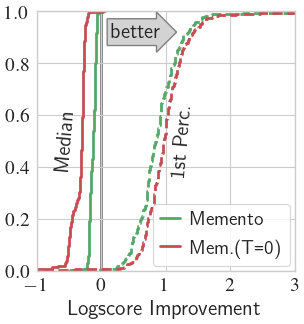

In [14]:
_median_and_tail = (
    comparison_deployment
    .query("varmetric == ['Score Median', 'Score Tail']")
    .pivot(
        index=["abr", "day", "selection", 'weight'],
        columns="varmetric",
        values="value_diff"
    )
    .reset_index()
)


grid = sns.FacetGrid(
    data=_median_and_tail,
    hue="abr",
    hue_order=[memento_name, memento_deterministic],
    palette=abr_palette,
    **eh.plot_utils.opts_square_small(is_grid=True)
)

grid.map_dataframe(
    sns.ecdfplot, x='Score Median', weights="weight",
)

grid.add_legend(title=None)


grid.map_dataframe(
    sns.ecdfplot, x='Score Tail', weights="weight",
    linestyle='--',
)

grid.set(
    ylabel="",
    xlabel="Logscore Improvement",
    xlim=(-1, 3),
    xticks=np.arange(-1, 3 + 1, 1),
)

# Touch up legend and add annotations.
legend = plt.gca().legend([
    f"{memento_name}",
    r"Mem.(T\texttt{=}0)",
    #"Median",
    #"1st P.",
], loc="lower right", handlelength=1, handletextpad=0.5,
    bbox_to_anchor=(1.02, -0.02),
)

plt.gca().text(
    0.55, 0.92, "better",
    ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))

plt.gca().text(
    -0.55, 0.5, "Median",
    ha="center", va="center", rotation=85, size=15,
    #bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1)
)
plt.gca().text(
    1.25, 0.5, "1st Perc.",
    ha="center", va="center", rotation=85, size=15,
    #bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1)
)

plt.axvline(0, color='gray', linestyle='-', zorder=0)
plt.savefig(plotdir / "ecdf_logscore_diff.pdf")
plt.show()

# Figure 11: Logscore Improvement in comparison to Fugu (daily)

While we cannot compare directly to a daily-retrained version of Fugu for lack of data, we can look at the logscore difference between Fugu (static) and Fugu (daily retrained from random samples of the last two weeks) in the past.

We can see that they have an almost identical median score, but retraining from random samples does not yield consistent tail score improvements.
For about 20% of days, the tail score is even _worse_ than Fugu(static), and for the remaining days the tail gains are significantly smaller than for Memento.

While the relationship between an ML model in a control loop with the overall QoE is hard to quantify, this may explain why we see considerably less improvement in stalls when using a model retrained from random samples.

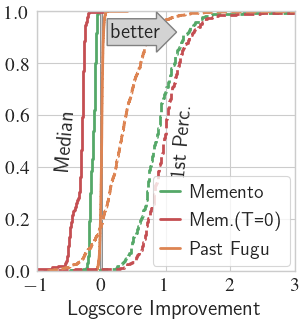

In [15]:
_median_and_tail_fugu = (
    comparison
    .query("(abr == @fugu_name) and day in @both_fugus")
    .dropna(subset=['value_diff'])
    .query("varmetric == ['Score Median', 'Score Tail']")
    .pivot(
        index=["abr", "day", "selection", 'weight'],
        columns="varmetric",
        values="value_diff"
    )
    .reset_index()
)


grid = sns.FacetGrid(
    data=pd.concat([_median_and_tail, _median_and_tail_fugu]),
    hue="abr",
    hue_order=[memento_name, memento_deterministic, fugu_name],
    palette=abr_palette,
    **eh.plot_utils.opts_square_small(is_grid=True)
)

grid.map_dataframe(
    sns.ecdfplot, x='Score Median', weights="weight",
)

grid.add_legend(title=None)


grid.map_dataframe(
    sns.ecdfplot, x='Score Tail', weights="weight",
    linestyle='--',
)

grid.set(
    ylabel="",
    xlabel="Logscore Improvement",
    xlim=(-1, 3),
    xticks=np.arange(-1, 3 + 1, 1),
)

# Touch up legend and add annotations.
legend = plt.gca().legend([
    f"{memento_name}",
    r"Mem.(T\texttt{=}0)",
    "Past Fugu",
], loc="lower right", handlelength=1, handletextpad=0.5,
    bbox_to_anchor=(1.02, -0.02),
)

plt.gca().text(
    0.55, 0.92, "better",
    ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))

plt.gca().text(
    -0.55, 0.5, "Median",
    ha="center", va="center", rotation=85, size=15,
    #bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1)
)
plt.gca().text(
    1.25, 0.5, "1st Perc.",
    ha="center", va="center", rotation=85, size=15,
    #bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1)
)

plt.axvline(0, color='gray', linestyle='-', zorder=0)
plt.savefig(plotdir / "ecdf_logscore_diff_with_past_fugu.pdf")
plt.show()

## Figure 4 (c): Relative SSIM improvement

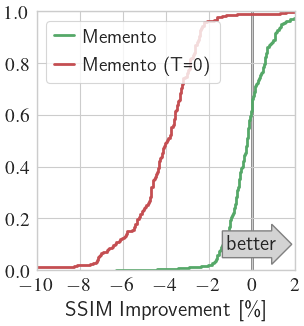

In [16]:
grid = sns.displot(
    kind='ecdf',
    data=comparison_deployment.query("varmetric == 'Mean SSIM'"),
    x='value_diff_rel',
    weights="weight",
    hue="abr", hue_order=[memento_name, memento_deterministic], palette=abr_palette,
    **eh.plot_utils.opts_square_small()
).set(
    ylabel="",
    xlabel="SSIM Improvement [\%]",
    xlim=(-10, 2),
    xticks=np.arange(-10, 2 + 1, 2)
)
grid.legend.set_title(None)

sns.move_legend(
    plt.gca(), "upper left", title=None,
    handlelength=1, handletextpad=0.5, #bbox_to_anchor=(1.02, -0.02),
)


plt.axvline(0, color='gray', linestyle='-', zorder=0)

plt.gca().text(
    0, 0.1, "better",
    ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))

plt.savefig(plotdir / "ecdf_ssim_rel.pdf")
plt.show()

## Figure 4 (d): Relative stall improvement

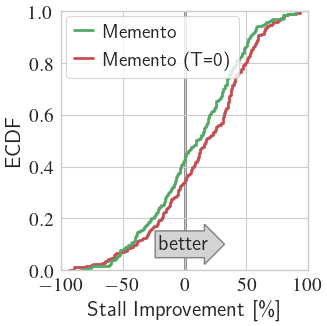

In [17]:
stalltimediff = (
    comparison_deployment.query("varmetric == 'Percent stalled'")
    # Flip such that less = better
    .assign(value_diff_rel=lambda df: -1*df['value_diff_rel'])
)

grid = sns.displot(
    kind='ecdf',
    data=stalltimediff,
    x='value_diff_rel',
    weights="weight",
    hue="abr", hue_order=[memento_name, memento_deterministic], palette=abr_palette,
    **eh.plot_utils.opts_square_small()
).set(
    ylabel="ECDF",
    xlabel="Stall Improvement [\%]",
    xlim=(-100, 100),
)
sns.move_legend(
    plt.gca(), "upper left", title=None,
    handlelength=1, handletextpad=0.5, bbox_to_anchor=(-0.02, 1.02),
)

plt.gca().text(
    0, 0.1, "better",
    ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))

plt.axvline(0, color='gray', linestyle='-', zorder=0)
plt.savefig(plotdir / "ecdf_stall_rel.pdf")
plt.show()

Where exactly do the lines cross zero? That is, on which fraction of days is Memento worse?

In [18]:
# Where do the lines cross 0?
((
    stalltimediff.query("value_diff_rel <= 0")
    .groupby("abr")["weight"].sum()
    
) / (
    stalltimediff
     .groupby("abr")["weight"].sum()
)).dropna()

abr
\textsf{Memento}                   0.425464
\textsf{Memento} (T\texttt{=}0)    0.341734
Name: weight, dtype: float64

# Timeseries plots [Fig. 1, 15, 16, 17]

Timeseries plots with a rolling mean and a (also rolling) 90% confidence interval.

In [19]:
def rolling(frame, days):
    """Prepare a frame so a rolling apply can be achieved by grouping by day.

    Only needed because pandas.rolling.apply only works per-column.
    
    Concretely, copy the frame and increase the day, so that in the end a given
    day contains data from the past `days` frames.
    """
    daycol = frame['day']
    last_day = daycol.max()
    copies = [frame.assign(day=daycol + pd.Timedelta(days=ind))
              for ind in range(days)]
    # Merge and remove days shifted into the future.
    return (
        pd
        .concat(copies)
        [lambda df: df['day'] <= last_day]
        .reset_index(drop=True)
    )

def bootstrap(
    data, metric=None,
    col="value", comp_col="value_feb",
    weight="abr_weight",  weight_comp="abr_weight_feb",
    estimator=weighted_mean_raw, difference=maxpd,
    n_resamples=1000, confidence_level=0.9, random_state=42,
    format=False,
    ):
    """Bootstrap the difference between two ABRs."""
    if metric is not None:
        data = data[lambda df: df['metric'] == metric]

    # Inputs for bootstrap: col, comp_col, weight
    if (weight is not None) and (weight_comp is not None):
        arrays = (
            data[col].values, data[comp_col].values,
            data[weight].values, data[weight_comp].values
        )
    else:
        arrays = (data[col].values, data[comp_col].values,)

    def _diff(*arrays):
        """Aggregate the arrays."""
        if (weight is not None) and (weight_comp is not None):
            x1, x2, w1, w2 = arrays
        else:
            x1, x2 = arrays
            w1, w2 = None, None

        if difference is None:
            return estimator(x1, w1)
        return difference(estimator(x1, w1), estimator(x2, w2))
    
    _est = _diff(*arrays)
    if len(arrays[0]) == 1:
        # Cannot bootstrap with only one day; return the single value.
        _ci = (_est, _est)
    else:
        _ci = stats.bootstrap(
            arrays, _diff, method='percentile',
            n_resamples=n_resamples,
            confidence_level=confidence_level,
            random_state=random_state
        ).confidence_interval

    if format:
        return f"{_est:.2f} [{_ci[0]:.2f}, {_ci[1]:.2f}]"
    return (_est, *_ci)


def plot_timeseries(
    data=None,
    x="day",
    window=14,
    metric=None,
    ax=None,
    color=None,
    alpha=0.2,
    label=None,
    bootstrap=bootstrap,
    bootstrap_kwargs=None,
    color_code=False,
    xdate=True,
    invert=tuple(),
    styles=None,
    **plot_kwargs
):
    """Plot a rolling average with bootstrapped confidence intervals."""
    if ax is None:
        ax = plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()
    if bootstrap_kwargs is None:
        bootstrap_kwargs = {}    
    if styles is not None and label in styles:
        plot_kwargs.update(linestyle=styles[label])

    if metric is not None:
        data = data.query("metric == @metric")
    data = data.sort_values(by="day")
    assert x == 'day'

    # Compute the rolling estimates.
    results = (
        rolling(data, window)
        .groupby("day")
        .apply(bootstrap, **bootstrap_kwargs)
    )
    x = results.index.values
    if not xdate:
        # Use #days instead of datetime.
        x = (x - x[0]) / np.timedelta64(1, "D")

    y = results.map(itemgetter(0)).values
    low = results.map(itemgetter(1)).values
    high = results.map(itemgetter(2)).values

    if label in invert:
        # Invert the sign so that lower values mean better.
        y, low, high = -y, -high, -low
    
    if not color_code:
        if window > 1:
            ax.fill_between(x, low, high, color=color, alpha=alpha)
        ax.plot(x, y, color=color, **plot_kwargs, label=label)
    else:
        green = sns.color_palette("deep")[2]
        red = sns.color_palette("deep")[3]

        if window > 1:
            # Increase: red, everything above 0
            ilow = np.where(low >= 0, low, 0)
            ihigh = np.where(high >= 0, high, 0)
            ax.fill_between(x, ilow, ihigh, color=red, alpha=alpha)
            # Decrease: green, everything below 0
            dlow = np.where(low <= 0, low, 0)
            dhigh = np.where(high <= 0, high, 0)
            ax.fill_between(x, dlow, dhigh, color=green, alpha=alpha)

        # Find crossing points for smooth color transition.
        # See: https://stackoverflow.com/a/70850749
        x1, x2 = np.stack([x[:-1],  x[1:]])[:,np.diff(y < 0)]
        y1, y2 = np.stack([y[:-1], y[1:]])[:,np.diff(y < 0)]
        xf = x1 + -y1 * (x2 - x1) / (y2 - y1)

        i = np.searchsorted(x, xf)
        x0 = np.insert(x, i, xf)
        y0 = np.insert(y, i, 0)

        above = y0.copy()
        above[above < 0] = np.nan
        below = y0.copy()
        below[below > 0] = np.nan

        ax.plot(x0, above, color=red, **plot_kwargs, label=label)
        ax.plot(x0, below, color=green, **plot_kwargs, label=label)

## Figure 1: Fugu (daily) vs Fugu (static)

The SSIM difference is very small, so we add a little zoom-in window to show that there is in fact some difference, but insignificant.

Note: computing the rolling confidence intervals takes some minutes.

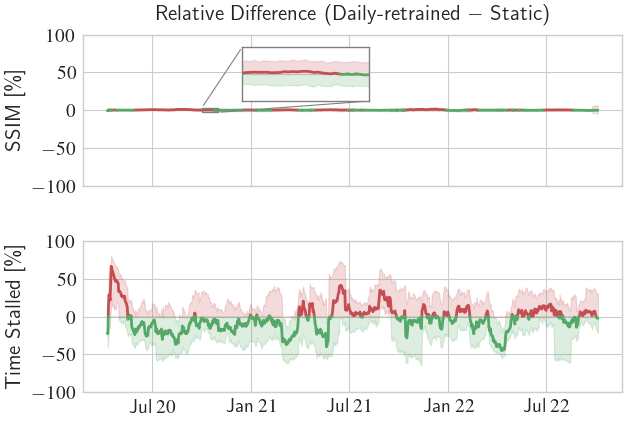

In [20]:
both_fugus = (  # Days for with we have both Fugu and FuguFeb.
    set(comparison.query("abr == @fugu_name")['day']).intersection(
        comparison.query("abr == @fugufeb_name")['day']
    )
)

firstpage_selection = comparison.query(
    "(day in @both_fugus) & (abr in [@fugu_name])"
    "& (varmetric in ['Mean SSIM', 'Percent stalled'])"
).dropna()

# Plot with a 1-month rolling window.
window=31

grid = sns.FacetGrid(
    data=firstpage_selection,
    row="varmetric", row_order=["Mean SSIM", "Percent stalled"],
    hue="abr", palette=abr_palette,
    aspect=eh.plot_utils.default_aspect * 2,
    height=eh.plot_utils.default_height / 2,
    sharey=False, despine=False,
).map_dataframe(
    plot_timeseries,
    window=window,
    color_code=True,
).set(
    title=None,
    ylim=(-100, 100),
    yticks=[-100, -50, 0, 50, 100],
    xlabel="",
)

# Manual adjustments
fig = plt.gcf()

# SSIM axis
fig.axes[0].set(
    #ylim=(-100, 100),
    ylabel="SSIM [\%]",
)
fig.axes[0].set_title(
    "Relative Difference (Daily-retrained $-$ Static)",
    pad=10,
)
# Stall axis
fig.axes[1].set(
    #xlabel="",
    #ylim=(-100, 100),
    ylabel="Time Stalled [\%]",
    
)
fig.axes[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
fig.axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

green = sns.color_palette("deep")[2]
red = sns.color_palette("deep")[3]

mini_lim=(-3, 3)
height=np.abs(mini_lim[1]) + np.abs(mini_lim[0])
mini_start = pd.to_datetime("2020-10-01")
mini_dur = pd.to_timedelta("30D")


_edgec = "gray"


miniax = plt.axes((0.35, 0.75, 0.2, 0.12))
for spine in miniax.spines.values():
    spine.set_edgecolor(_edgec)

rect = patches.Rectangle(
    (mini_start, mini_lim[0]), mini_dur, height, linewidth=1,
    edgecolor=_edgec, facecolor='none', zorder=10
)
fig.axes[0].add_patch(rect)


_start = mini_start - pd.to_timedelta(f"{window}D")
_end = mini_start + mini_dur + pd.to_timedelta(f"{window}D")

plot_timeseries(
    data=firstpage_selection.query(
        "(varmetric == 'Mean SSIM') and (day >= @_start) and (day <= @_end)"
    ),
    ax=miniax,
    window=window,
    color_code=True,
)
miniax.set(
    xlabel=None, ylabel=None,
    xlim=(mini_start, mini_start + mini_dur),
    ylim=mini_lim,
    yticks=[],
    xticks=[],
)
fig.axes[0].annotate(
    "", xy=(mini_start, mini_lim[1]),
    xytext=(0.295, 0.915), textcoords="axes fraction",
    arrowprops=dict(arrowstyle="-", color=_edgec),
)
fig.axes[0].annotate(
    "", xy=(mini_start + mini_dur, mini_lim[0]),
    xytext=(0.535, 0.561), textcoords="axes fraction",
    arrowprops=dict(arrowstyle="-", color=_edgec),
)



fig.align_ylabels()
#fig.tight_layout()
plt.savefig(plotdir / "firstpage_puffer.pdf")
plt.show()

### Figure 17: Logscores Improvement with Memento over time

For Memento, and for Memento (T=0). We use a two-week sliding window as the time interval is shorter than before.

Logscores are not a linear scale, so we plot the absolute difference.

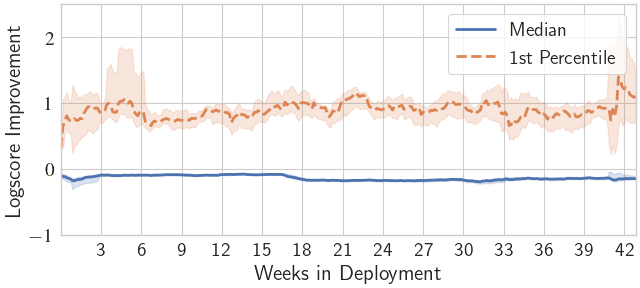

In [21]:
current_logscores = comparison.query(
    "(day >= @deployment_start) & (abr == @memento_name)"
    " & (varmetric in ['Score Median', 'Score Tail'])"
).dropna()

# Nicer xticks.
n_days = (current_logscores.day.max() - current_logscores.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3

grid = sns.FacetGrid(
    data=current_logscores,
    hue="varmetric", hue_order=['Score Median', 'Score Tail'],
    **eh.plot_utils.opts_short(is_grid=True)
).map_dataframe(
    plot_timeseries,
    window=14,
    bootstrap_kwargs=dict(n_resamples=1000, difference=diff),
    xdate=False,
    styles={"Score Tail": "--"},
).set(
    title=None,
    ylim=(-1, 2.5),
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="Logscore Improvement",
)

# Nicer legend.
fig = plt.gcf()
h, l = fig.axes[0].get_legend_handles_labels()
fig.axes[0].legend(
    title=None, handles=h, labels=["Median", "1st Percentile"],
    loc="upper right",
)

plt.savefig(plotdir / "logscore_improvement.pdf")
plt.show()

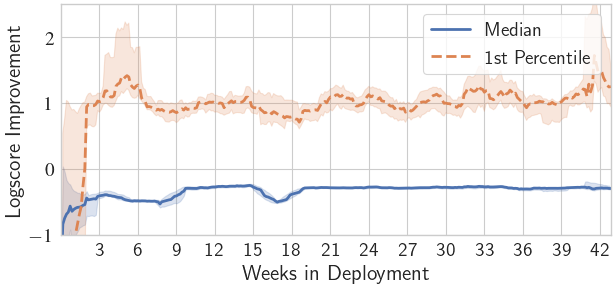

In [22]:
current_logscores_t0 = comparison.query(
    "(day >= @deployment_start) & (abr == @memento_deterministic)"
    " & (varmetric in ['Score Median', 'Score Tail'])"
)#.dropna(subset="value")

n_days = (current_logscores_t0.day.max() - current_logscores_t0.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3

grid = sns.FacetGrid(
    data=current_logscores_t0,
    hue="varmetric", hue_order=['Score Median', 'Score Tail'],
    **eh.plot_utils.opts_short(is_grid=True)
).map_dataframe(
    plot_timeseries,
    window=14,
    bootstrap_kwargs=dict(n_resamples=1000, difference=diff),
    xdate=False,
    styles={"Score Tail": "--"},
).set(
    title=None,
    ylim=(-1, 2.5),
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="Logscore Improvement",
)

# Nicer legend.
fig = plt.gcf()
h, l = fig.axes[0].get_legend_handles_labels()
fig.axes[0].legend(
    title=None, handles=h, labels=["Median", "1st Percentile"],
    loc="upper right",
)

plt.savefig(plotdir / "logscore_improvement_deterministic.pdf")
plt.show()

### Figure 15a and 16a: SSIM over time; raw (14) and smoothed (15)

For Memento and Memento (T=0) in the current deployment.
For the smoothed case, again with 14-day rolling window and CI.

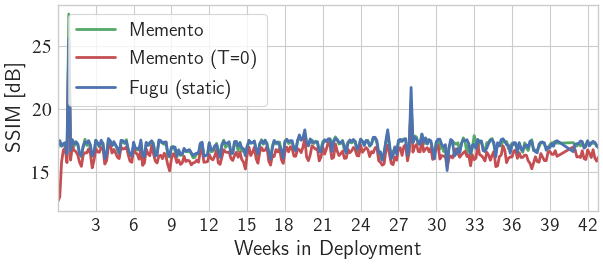

In [23]:
ssim_over_time = comparison.query(
    "(day >= @deployment_start) & (abr in @abr_order_short)"
    #" & (day not in @worst_days)"
    " & (varmetric in ['Mean SSIM'])"
).dropna()

n_days = (ssim_over_time.day.max() - ssim_over_time.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3


grid = sns.relplot(
    kind='line',
    data=ssim_over_time,
    x="days_running", y="value",
    hue="abr", hue_order=abr_order_short, palette=abr_palette,
    **eh.plot_utils.opts_short()
).set(
    title=None,
    #ylim=(-100, 100),
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="SSIM [dB]",
)

plt.legend(title=None)
plt.savefig(plotdir / "ssim.pdf")
plt.show()

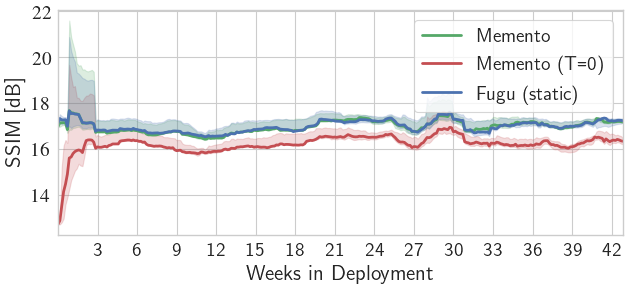

In [24]:
since_bugfix = ssim_over_time.query(
    "(day >= @deployment_start) & (abr in @abr_order_short)"
    #" & (day not in @worst_days)"
    " & (varmetric in ['Mean SSIM'])"
).dropna()

n_days = (ssim_over_time.day.max() - ssim_over_time.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3


grid = sns.FacetGrid(
    data=ssim_over_time,
    hue="abr", hue_order=abr_order_short, palette=abr_palette,
    **eh.plot_utils.opts_short(is_grid=True)
).map_dataframe(
    plot_timeseries,
    window=14,
    bootstrap_kwargs=dict(n_resamples=1000, difference=None),
    xdate=False,
).set(
    title=None,
    #ylim=(0, 0.4),
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="SSIM [dB]",
)
plt.legend()

plt.savefig(plotdir / "ssim_smoothed.pdf")
plt.show()

### Figure 15b and 16b: Stalls over time; raw (14) and smoothed (15)

For Memento and Memento (T=0) in the current deployment.
For the smoothed case, again with 14-day rolling window and CI.

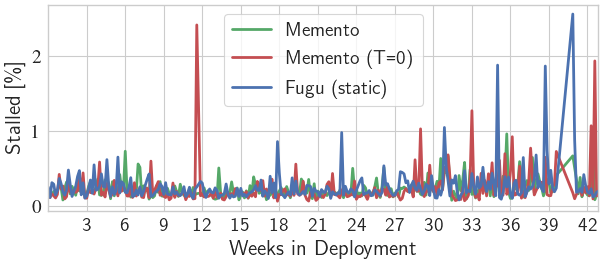

In [25]:
stalls_over_time = comparison.query(
    "(day >= @deployment_start) & (abr in @abr_order_short)"
    #" & (day not in @worst_days)"
    " & (varmetric in ['Percent stalled'])"
).dropna()

n_days = (stalls_over_time.day.max() - stalls_over_time.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3


grid = sns.relplot(
    kind='line',
    data=stalls_over_time,
    x="days_running", y="value",
    hue="abr", hue_order=abr_order_short, palette=abr_palette,
    **eh.plot_utils.opts_short()
).set(
    title=None,
    #ylim=(-100, 100),
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="Stalled [\%]",
)

plt.legend(title=None, loc="upper center")

plt.savefig(plotdir / "stalls.pdf")
plt.show()

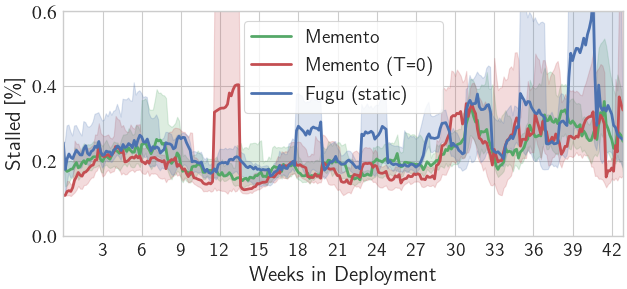

In [26]:
stalls_over_time = comparison.query(
    "(day >= @deployment_start) & (abr in @abr_order_short)"
    #" & (day not in @worst_days)"
    " & (varmetric in ['Percent stalled'])"
).dropna()

n_days = (stalls_over_time.day.max() - stalls_over_time.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3


grid = sns.FacetGrid(
    data=stalls_over_time,
    hue="abr", hue_order=abr_order_short, palette=abr_palette,
    **eh.plot_utils.opts_short(is_grid=True)
).map_dataframe(
    plot_timeseries,
    window=14,
    bootstrap_kwargs=dict(n_resamples=1000, difference=None),
    xdate=False,
).set(
    title=None,
    ylim=(0, 0.6),
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="Stalled [\%]",
)
plt.legend(loc="upper center")

plt.savefig(plotdir / "stalls_smoothed.pdf")
plt.show()

### Figure 10: Performance drop in previous deployment

We found that settings T=0, i.e. not rejecting noise, can lead to significant degradation over time.

This is noticeable primarily in a drop in image quality.

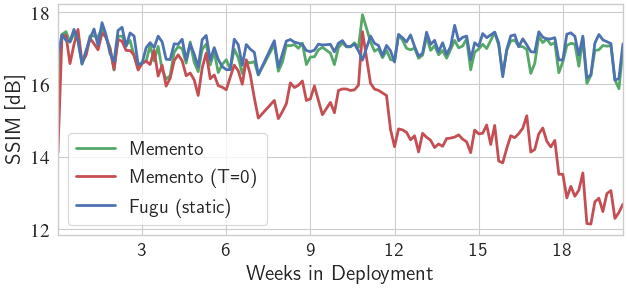

In [27]:
last_dep = comparison.query(
    "(day >= @old_deployment_start) & (day <= @deployment_start)"
    " & (abr in @abr_order_short)"
    #" & (day not in @worst_days)"
    " & (varmetric in ['Mean SSIM'])"
).dropna()

n_days = (last_dep.day.max() - last_dep.day.min()).days
tickfreq = 7 * 3  # every 3 weeks
xticks = np.arange(0, n_days + 1, tickfreq)
xticklabels = np.arange(len(xticks)) * 3


grid = sns.FacetGrid(
    data=last_dep,
    hue="abr", hue_order=abr_order_short, palette=abr_palette,
    **eh.plot_utils.opts_short(is_grid=True)
).map_dataframe(
    plot_timeseries,
    window=1,
    bootstrap_kwargs=dict(n_resamples=1000, difference=None),
    xdate=False,
).set(
    title=None,
    xlabel="Weeks in Deployment",
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlim=(0, n_days),
    ylabel="SSIM [dB]",
)
plt.legend()

plt.savefig(plotdir / "failure_deterministic.pdf")
plt.show()

# 2D aggregate plots

Plots with the same style as the Puffer paper, with Stalls on the x and SSIM on the y axis.

To help compare the new results and put them in context,
we add specific datapoints for Fugu (daily) and Fugu (static) for the days
where both were deployed at the same time. This helps to highlight the differnece between random and density-based daily retraining.

But first we need some helpers to actually plot this.

In [28]:
# We need a wide-form dataframe for these plots.
comparison_wide = (
    comparison
    .pivot(
        index=["abr", "day", "selection"], columns="varmetric", values="value"
    )
).reset_index()

both_fugus = (  # Days for with we have both Fugu and FuguFeb.
    set(comparison.query("abr == @fugu_name")['day']).intersection(
        comparison.query("abr == @fugufeb_name")['day']
    )
)

comparison_with_past = pd.concat([
    (
        comparison_wide
        .query("(day > @deployment_start) and (abr != @fugu_name)")
    ),
    (
        comparison_wide
        .query("(day in @both_fugus) and (abr in [@fugu_name, @fugufeb_name])")
        .assign(abr = lambda df: [f"Past {_abr}" for _abr in df['abr']])
    )
])

abr_palette_extended = {
    **abr_palette,
    f"Past {fugu_name}": sns.color_palette('dark')[1],
    f"Past {fugufeb_name}": sns.color_palette('dark')[0],
}


def plot_2d(*, data, x, y, w=None, ax=None,
            n_resamples=1000, confidence_level=0.9, random_state=42,
            **kwargs):
    if ax is None:
        ax = plt.gca()

    # Tuples for compatibility with bootstrap.
    _x = (data[x].values,)
    _y =( data[y].values,)
    if w is not None:
        _w = data[w].values
        _x = (*_x, _w)
        _y = (*_y, _w)

    _x_est = weighted_mean_raw(*_x)
    _x_ci = stats.bootstrap(
        _x, weighted_mean_raw, method='percentile',
        n_resamples=n_resamples,
        confidence_level=confidence_level,
        random_state=random_state
    ).confidence_interval
    _y_est = weighted_mean_raw(*_y)
    _y_ci = stats.bootstrap(
        _y, weighted_mean_raw, method='percentile',
        n_resamples=n_resamples,
        confidence_level=confidence_level,
        random_state=random_state
    ).confidence_interval

    # A bit weird, the error bars must be relative, absolute values.
    # Also they need shape (2, n) for the errorbar function.
    _xerr = np.abs(np.array(_x_ci) - _x_est).reshape(2, 1)
    _yerr = np.abs(np.array(_y_ci) - _y_est).reshape(2, 1)

    ax.errorbar(_x_est, _y_est, xerr=_xerr, yerr=_yerr, **kwargs)

### Figure 14a: 2D performance

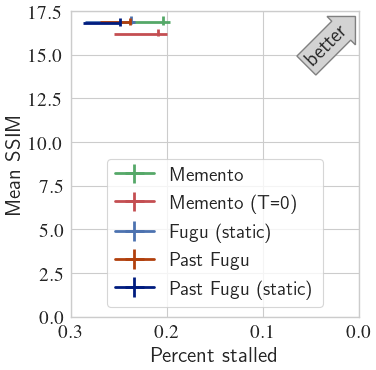

In [29]:
grid = sns.FacetGrid(
    data=comparison_with_past,
    hue="abr", palette=abr_palette_extended,
    despine=False,
    height=4,
    legend_out=False,
).map_dataframe(
    plot_2d,
    x="Percent stalled", y="Mean SSIM", w="Time streamed",
).add_legend(title="", loc="lower center").set(
    xlim=(0.30, 0.0),
    ylim=(0, 17.5),
)

ax = plt.gca()
ax.text(
    0.89, 0.89, "better", transform=ax.transAxes,
    ha="center", va="center", rotation=45, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))

plt.savefig(plotdir / "aggregated_2d.pdf")
plt.show()

### Figure 14b: 2D performance, zoomed in.

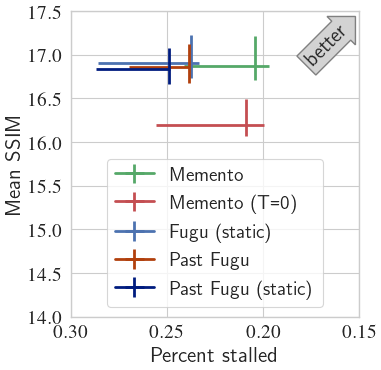

In [30]:
grid = sns.FacetGrid(
    data=comparison_with_past,
    hue="abr", palette=abr_palette_extended,
    despine=False,
    height=4,
    legend_out=False,
).map_dataframe(
    plot_2d,
    x="Percent stalled", y="Mean SSIM", w="Time streamed",
).add_legend(title="", loc="lower center").set(
    xlim=(0.3, 0.15),
    ylim=(14, 17.5),
)

ax = plt.gca()
ax.text(
    0.89, 0.89, "better", transform=ax.transAxes,
    ha="center", va="center", rotation=45, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.2", fc="lightgray", ec="gray", lw=1))


plt.savefig(plotdir / "aggregated_2d_zoom.pdf")
plt.show()

# Density Increase and Retraining

Finally, we investigate how often Memento retrained in deployment, i.e. how often the threshold for the relative coverage increase was reached.

In [31]:
all_stats = []
for deploykey, deploydir in config.memento_model_directories.items():
    if not Path(deploydir).is_absolute():
        # If it's relative, it's relative to the base dir, not to `notebooks/`.`
        deploydir = f'../{deploydir}'

    for model_index in range(5):
        modeldir = Path(deploydir) / str(model_index)
        for daydir in modeldir.iterdir():
            try:
                day = pd.to_datetime(daydir.name)
            except ValueError:
                continue # logs, checkpoint
            
            try:
                _stats = eh.data.read_json(
                    daydir / f"stats_{model_index}.json.gz")
            except FileNotFoundError:
                pass
            _stats.update(model=model_index, day=day, abr=deploykey)
            all_stats.append(_stats)

DAY = pd.Timedelta(days=1)
statframe = (
    pd
    .DataFrame
    .from_records(all_stats)
    # Add iteration counter
    .assign(
        iteration=lambda df: (
        ((df['day'] - df['day'].min()) / DAY ).astype(int) + 1),
        # For each frame, apply name mapping and use a categorical
        # datatype to ensure consistent ordering and to save space.
        abr=lambda df: pd.Categorical(
            df['abr'].replace(name_mapping), abr_order),
    )
    .sort_values(by='day')
)

Retraining days for Memento.

In [32]:
training_current_deployment = (
    statframe.query(
        "(model==0) and (abr in [@memento_name, @memento_deterministic])"
        " and (day >= @deployment_start) and (day < @cutoff_day)"
    )
    .assign(day_since_start=lambda df: (df['day'] - df['day'].min()).dt.days)
)

# After bugfix:
display(
    training_current_deployment
    .loc[lambda df: df['retrain'], ["abr", 'day', 'day_since_start']]
    .sort_values(by=["abr", 'day_since_start'])
)

display(
    training_current_deployment
    .groupby("abr")
    ['retrain']
    .sum()
)

,abr,day,day_since_start
363,\textsf{Memento},2022-09-20,1
108,\textsf{Memento},2022-09-22,3
123,\textsf{Memento},2022-09-26,7
421,\textsf{Memento},2022-09-27,8
331,\textsf{Memento},2023-01-13,116
283,\textsf{Memento},2023-04-22,215
157,\textsf{Memento},2023-04-27,220
2284,\textsf{Memento} (T\texttt{=}0),2022-09-20,1
2478,\textsf{Memento} (T\texttt{=}0),2022-09-21,2
2615,\textsf{Memento} (T\texttt{=}0),2022-09-25,6


abr
\textsf{Memento}                    7
\textsf{Memento} (T\texttt{=}0)    14
\textsf{Fugu}                       0
\textsf{Fugu} (static)              0
Name: retrain, dtype: int64

## Figure 4 (b): Retraining

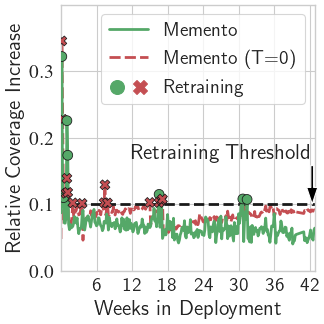

In [33]:
n_days = training_current_deployment['day_since_start'].max()
tickfreq = 6   # every n weeks
xticks = np.array(range(0, n_days, 7 * tickfreq))
xticklabels = np.arange(len(xticks)) * tickfreq

# For simplicity, show only model 0. The other have the same pattern
# (uncomment to verify)
xrange = training_current_deployment['day_since_start'].agg(['min', 'max'])
grid = sns.relplot(
    kind='line',
    data=training_current_deployment,
    x='day_since_start',
    y='coverage_increase',
    hue="abr", hue_order=[memento_name, memento_deterministic],
    palette=abr_palette,
    style="abr", style_order=[memento_name, memento_deterministic],
    **eh.plot_utils.opts_square_small()
).set(
    xlim=xrange,
    xticks=xticks[1:],
    xticklabels=xticklabels[1:],
    xlabel="Weeks in Deployment",
    ylim=(0, 0.4),
    yticks=[0, 0.1, 0.2, 0.3],
    ylabel="Relative Coverage Increase"
)

ax = plt.gca()

# On top, put markers for retraining events.
sns.scatterplot(
    ax=ax,
    data=training_current_deployment.query("retrain"),
    x='day_since_start',
    y='coverage_increase',
    hue="abr", hue_order=[memento_name, memento_deterministic],
    style="abr", style_order=[memento_name, memento_deterministic],
    size=10, edgecolor='k', zorder=42,
    palette=abr_palette,
)


# Manual adjustments
h, l = ax.get_legend_handles_labels()
ax.legend(
    title=None,
    handles=[h[0], h[1], (h[2], h[3])],
    labels=["Memento", "Memento (T=0)", "Retraining"],
    # Using this map we can put both retraining symbols next to each other.
    handler_map={tuple: HandlerTuple(ndivide=None)}
)

# Force Memento (first line plotted) to be on top.
ax.get_children()[0].set_zorder(10)

# Add line for threshold
ax.plot(xrange, [0.1, 0.1], 'k--')
ax.annotate("Retraining Threshold", xy=[xrange.max() * 0.99, 0.1],
            xytext=(0, 30), textcoords='offset points',
            ha="right", va="bottom",
            arrowprops=dict(facecolor='black', width=2, headwidth=8,))

plt.tight_layout()
plt.savefig(plotdir / "memento_coverage_increase.pdf")
plt.show()